In [1]:
from pathlib import Path 
import pydicom 
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [2]:
labels= pd.read_csv("stage_2_train_labels.csv")

In [3]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [4]:
labels=labels.drop_duplicates("patientId") #removing duplicates

In [5]:
ROOT_PATH=Path("stage_2_train_images/")
SAVE_PATH=Path("Processed")


Data preprocessing

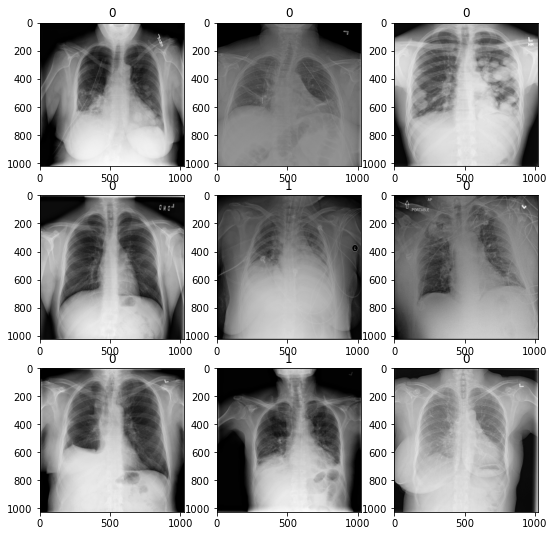

In [6]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]
        
        axis[i][j].imshow(dcm, cmap="gray")
        axis[i][j].set_title(label)
        c+=1

Converting images in dicom format to numpy arrays and normalizing the data by calculating mean and std. deviation of the pixels 


In [7]:
sums, sums_squared=0,0

for c,patient_id in enumerate(tqdm(labels.patientId )):
    patient_Id=labels.patientId.iloc[c]
    dcm_path=ROOT_PATH/patient_id
    dcm_path=dcm_path.with_suffix(".dcm")
    dcm=pydicom.read_file(dcm_path).pixel_array/255
    
    dcm_array=cv2.resize(dcm,(224,224)).astype(np.float16) #resizing the image to 224x224 for easier evaluation by the model
    #and converting it to float 16 to reduce space.
    
    label=labels.Target.iloc[c]
    
    train_or_val="train" if c< 24000 else "val"
    
    current_save_path=SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True,exist_ok=True)
    
    np.save(current_save_path/patient_id, dcm_array)
    
    normalizer=224*224 
    if train_or_val=="train":
        sums+=np.sum(dcm_array)/normalizer
        sums_squared+=(dcm_array**2).sum()/normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [8]:
mean=sums/24000
std=np.sqrt((sums_squared/24000)-mean**2)

In [9]:
mean, std

(0.4903962485384803, 0.24795070634161256)

Training the model

In [10]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


In [11]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [12]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  
                                    transforms.Normalize(0.49, 0.248),  #mean,std deviation
                                    transforms.RandomAffine( #Data augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  
                                    transforms.Normalize([0.49], [0.248]),  
])



In [13]:
train_dataset = torchvision.datasets.DatasetFolder("Processed/train/",loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder("Processed/val/",loader=load_file, extensions="npy", transform=val_transforms)

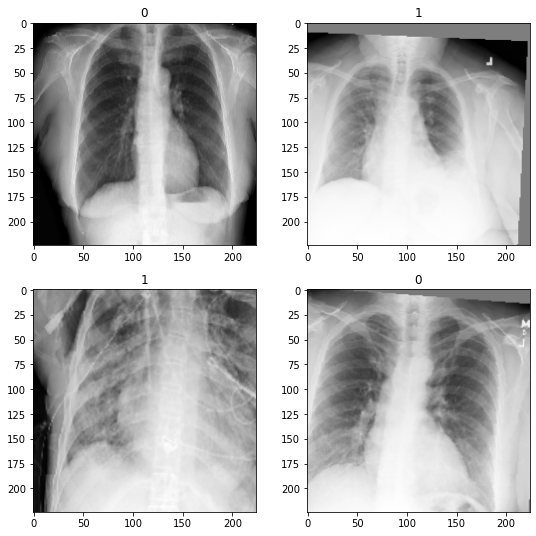

In [14]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 24000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="gray")
        axis[i][j].set_title(label)

In [15]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [16]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self,weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()   
      
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #changing the input channels from 3 to 1
        
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)  #changing output features from 1000 to 1
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4) #lr:initial learning rate
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight])) #loss function 
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Converting to float for loss calculation
        pred = self(x_ray)[:,0] 
        loss = self.loss_fn(pred, label)  #computation of loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int())) #.sigmoid: to convert prediction to probability
        return loss
    
    
    def training_epoch_end(self, outs): #used to log the accuracy on the whole training set after and epoch ends
        
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  

        loss = self.loss_fn(pred, label)
        
        
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
       
        return [self.optimizer] # returns lists of all optimizers


In [25]:
model=PneumoniaModel()

In [26]:
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10, #storing the 10 best models based on highest validation accuracy 
    mode='max')

In [27]:
gpus = 1 
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=5)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [28]:
trainer.fit(model,train_loader,val_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\sauna\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\sauna\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = PneumoniaModel.load_from_checkpoint("weights/weights_3.ckpt") #weight1: Not trained with the weighted loss
#weigth3: Trained with a weighted loss
model.eval()
model.to(device)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [30]:
preds=[]
labels=[]

with torch.no_grad(): #gradients not necessary as raw prediction required
    for data, label in tqdm(val_dataset):
        data=data.to(device).float().unsqueeze(0) #.unsqueeze(0) adds batch axis infront of all other axis
        pred=torch.sigmoid(model(data)[0].cpu()) #converting raw model outputs to probability, removing batch channel dimension and copying output to the cpu
        preds.append(pred)
        labels.append(label)
preds=torch.tensor(preds)
labels=torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [31]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.7652757167816162
Val Precision: 0.48819640278816223
Val Recall: 0.8545454740524292
Confusion Matrix:
 tensor([[1537.,  542.],
        [  88.,  517.]])
Confusion Matrix 2:
 tensor([[1537.,  542.],
        [  88.,  517.]])


Model has high recall therefore it rarely misses cases of pneumonia but precision being at 0.48 means many patients which do not have pneumonia are classified falsely 

Confusion matrix:
1537 are are negative patients
517 are positive patients
88 patients who have pneumonia are misclassified as negative
547 patients who don't have pneumonia are tested as positive(high false positive rate)

*without weighted loss (i.e. weight_1) we will have higher false negative rate which is more dangerous


Implementing class activation map

In [32]:
t_model=torchvision.models.resnet18()
t_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
list(t_model.children())[:-2] #extracting the last convolutional layer that is at layer(4) (1) basic block

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [34]:
torch.nn.Sequential(*list(t_model.children()))[:-2]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [35]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18() 
        
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #changing the input channels from 3 to 1
       
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1) #changing output features from 1000 to 1
        
        
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])   # Extraction of the feature map
    def forward(self, data):
        
        
        feature_map = self.feature_map(data) # Computation of feature map
        
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1)) #compresses 7x7x512 feature map into a tensor of size 1x1x512 by taking the mean along the last axis
        print(avg_pool_output.shape)
        
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print(avg_pool_output_flattened.shape)
        
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map
    

In [36]:
model=PneumoniaModel.load_from_checkpoint("weights/weights_3.ckpt",strict=False)
model.eval()

C:\Users\sauna\anaconda3\lib\site-packages\pytorch_lightning\core\saving.py:205: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map.5.0.conv1.weight', 'feature_map.5.0.bn1.weight',

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [37]:
def cam(model,img):
    with torch.no_grad():
        pred,features=model(img.unsqueeze(0))
    features=features.reshape((512,49)) #reducing the calculations
    weight_params=list(model.model.fc.parameters())[0]
    weight=weight_params[0].detach()
    
    
    cam=torch.matmul(weight,features)
    cam_img=cam.reshape(7,7).cpu()
    return cam_img,torch.sigmoid(pred)

In [38]:
def visualize(img,cam,pred):
    img=img[0] #removing channel dimension of the X-ray image
    cam=transforms.functional.resize(cam.unsqueeze(0),(224,224))[0]
    
    fig,axis=plt.subplots(1,2)
    axis[0].imshow(img,cmap="gray")
    axis[1].imshow(img,cmap="gray")
    axis[1].imshow(cam,alpha=0.5,cmap="jet")
    plt.title(pred>0.5)

In [39]:
img=val_dataset[-6][0]
activation_map,  pred=cam(model,img)

torch.Size([1, 512, 1, 1])
torch.Size([512])


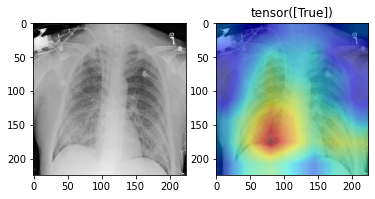

In [40]:
visualize(img, activation_map, pred)